In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform, randint, loguniform
from xgboost import XGBRegressor
import requests
from sklearn.model_selection import GridSearchCV
import pickle

In [58]:
url = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv"
api_key = "8a2e276d791143c0ad61eb26ae0999a28ecd9e34"
api_url = f'https://api.census.gov/data/2022/acs/acs5?get=NAME,B19013_001E&for=zip%20code%20tabulation%20area:*&key={api_key}'
df = pd.read_csv(url)
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,1565930130,20141104T000000,4,3.25,3760,4675,2.0,0,0,3,...,2740,1020,2007,0,98038,47.3862,-122.048,3280,4033,429900.0
1,3279000420,20150115T000000,3,1.75,1460,7800,1.0,0,0,2,...,1040,420,1979,0,98023,47.3035,-122.382,1310,7865,233000.0
2,194000575,20141014T000000,4,1.00,1340,5800,1.5,0,2,3,...,1340,0,1914,0,98116,47.5658,-122.389,1900,5800,455000.0
3,2115510160,20141208T000000,3,1.75,1440,8050,1.0,0,0,3,...,1440,0,1985,0,98023,47.3187,-122.390,1790,7488,258950.0
4,7522500005,20140815T000000,2,1.50,1780,4750,1.0,0,0,4,...,1080,700,1947,0,98117,47.6859,-122.395,1690,5962,555000.0


In [59]:
df.loc[df['id'] == 2402100895, 'bedrooms'] = 3

In [60]:
df.shape

(20000, 21)

In [61]:
df['view'].value_counts()

,count
view,
0,18030
2,889
3,471
1,311
4,299


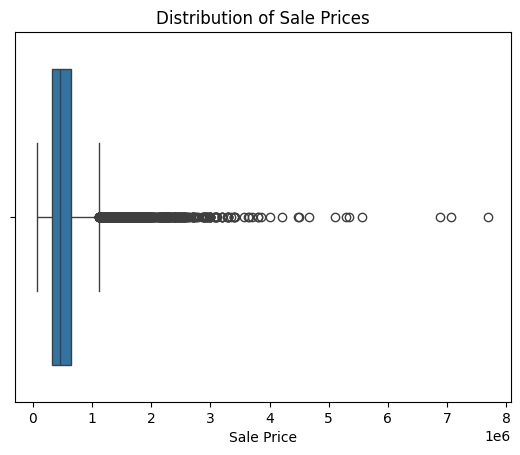

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df['price'])
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.show()

In [63]:
def handle_age_at_sale(df, method='adjust'):
    # This function processes a DataFrame to calculate the 'age_at_sale' for properties.
    # It addresses potential data quality issues where 'yr_built' might be later than 'sale_year'.

    if method == 'nan':
        # Option 1: Replace invalid ages with NaN (Not a Number).
        df['age_at_sale'] = df['sale_year'] - df['yr_built']
        # Calculate initial age.
        df.loc[df['age_at_sale'] < 0, 'age_at_sale'] = np.nan
        # Use .loc[] for label-based indexing to select rows where 'age_at_sale' is negative
        # and assign np.nan to those specific cells.

    elif method == 'zero':
        # Option 2: Replace invalid ages with 0.
        # This addresses the issue of "pre-built" homes
        df['age_at_sale'] = df['sale_year'] - df['yr_built']
        # Calculate initial age.
        df.loc[df['age_at_sale'] < 0, 'age_at_sale'] = 0
        # Conditionally set negative ages to 0 using .loc[].

    elif method == 'adjust':
        # Option 3: Adjust 'yr_built' to 'sale_year' for invalid entries.
        df.loc[df['yr_built'] > df['sale_year'], 'yr_built'] = df['sale_year']
        # Here, we're directly modifying the 'yr_built' column for rows where it's
        # logically impossible. This impacts the original 'yr_built' data.
        df['age_at_sale'] = df['sale_year'] - df['yr_built']

    else:
        raise ValueError("Method must be 'nan', 'zero', or 'adjust'")
    return df

In [64]:
df['date'] = pd.to_datetime(df['date'].str.replace('T000000', ''), errors='coerce') # Conver  'date' string column to datetime objects & removing the time suffix
df['sale_year'] = df['date'].dt.year # Extract year from dt object.
df['sale_month'] = df['date'].dt.month # Extract month from dt object.
df['sale_day'] = df['date'].dt.dayofweek # Extract day of the week (Monday=0, Sunday=6)
df['renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0) # Create binary feature where 1 = rennovated and 0 = not rennovated
df['low_grade'] = (df['grade'] <= 3).astype(int) # Binary feature where 1 = low grade and 0 = not low grade
df['high_grade'] = (df['grade'] >= 11).astype(int) # Binary feature where 1 = high grade and 0 = not high grade
df['sqft_living_x_grade'] = df['sqft_living'] * df['grade'] # Interaction feature made by multiplying living square footage by property grade.
df['waterfront_x_sqft_living'] = df['waterfront'] * df['sqft_living'] # Interaction feature for waterfront properties scaled by living square footage.
df['has_basement'] = np.where(df['sqft_basement'] > 0, 1, 0) # Binary feature where 1 = has a basement and 0 = no basement

In [65]:
df = handle_age_at_sale(df, method='adjust') # Call 'age_at_sale' and handle data inconsistencies, using the 'adjust' method.
print(df[df['yr_built'] > df['sale_year']][['date', 'yr_built', 'sale_year']]) # Check for inconsistencies

Empty DataFrame
Columns: [date, yr_built, sale_year]
Index: []


In [66]:
df['zipcode'] = df['zipcode'].astype(str).str.zfill(5) # Ensures the 'zipcode' column is a 5-digit string, padding with leading zeros for consistent merging.

url = f'https://api.census.gov/data/2022/acs/acs5?get=NAME,B19013_001E&for=zip%20code%20tabulation%20area:*&key={api_key}'
response = requests.get(url)

if response.status_code == 200: # Checks if the API request was successful (HTTP status code 200 means OK).
    income_data = response.json() # Parses the JSON response from the API into a Python list of lists.
    income_df = pd.DataFrame(income_data[1:], columns=income_data[0]) # Converts the list of lists into a Pandas DataFrame, using the first sublist as column headers.
    income_df = income_df.rename(columns={'B19013_001E': 'median_income', 'zip code tabulation area': 'zipcode'}) # Renames the API's column names to more descriptive ones ('median_income' and 'zipcode').
    income_df['zipcode'] = income_df['zipcode'].astype(str).str.zfill(5) # Standardizes the 'zipcode' format in the income data to ensure proper merging.
    income_df['median_income'] = pd.to_numeric(income_df['median_income'], errors='coerce') # Converts the 'median_income' column to a numeric type, coercing any non-numeric values to NaN.

    # Merge with housing data
    df = df.merge(income_df[['zipcode', 'median_income']], on='zipcode', how='left') # Performs a left merge to add 'median_income' from the Census data to the main housing DataFrame based on 'zipcode'.
    print(df[['zipcode', 'median_income']].head()) # Prints the head of the merged 'zipcode' and 'median_income' columns to verify the merge.
else:
    print("Error fetching data:", response.status_code) # Prints an error message if the API request failed, including the HTTP status code.
    print("Response content:", response.text) # Prints the full content of the API's response to help debug the error.

  zipcode  median_income
0   98038         135304
1   98023          98057
2   98116         129924
3   98023          98057
4   98117         166029


In [67]:
url = 'https://api.census.gov/data/2015/acs/acs5?get=B25010_001E,B12001_001E,B12001_002E,B12001_003E,B12001_004E,B12001_005E,B12001_006E,B25001_001E,B25003_002E,B25003_003E,B23025_001E,B23025_003E,B23025_005E,B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15002_001E,B15002_010E,B15002_011E,B15002_012E,B15002_013E,B15002_014E,B15002_015E,B15002_016E,B15002_017E,B15002_018E,B15002_019E,B15002_020E,B15002_021E,B15002_022E,B15002_023E&for=zip%20code%20tabulation%20area:*' # Defines the Census API URL to retrieve specific ACS 5-year demographic variables for all ZCTAs in 2015.

response = requests.get(url) # Sends an HTTP GET request to the constructed Census API URL.

if response.status_code == 200:
    data = response.json()
    df_census = pd.DataFrame(data[1:], columns=data[0])

    numeric_cols = [col for col in df_census.columns if col.startswith('B')] # Identifies all columns that start with 'B' (Census variable IDs) as potential numeric columns.
    df_census[numeric_cols] = df_census[numeric_cols].apply(pd.to_numeric, errors='coerce') # Converts identified Census variable columns to numeric type, coercing non-numeric values to NaN.

    df_census = df_census.rename(columns={'zip code tabulation area': 'zipcode'}) # Renames the 'zip code tabulation area' column to 'zipcode' for consistency.
    df_census['zipcode'] = df_census['zipcode'].astype(str).str.zfill(5) # Standardizes the 'zipcode' column to ensure a 5-digit string format with leading zeros.

    df_census['avg_household_size_2015'] = df_census['B25010_001E'] # Creates a new feature for average household size using the corresponding Census variable.
    df_census['percent_married_2015'] = (df_census['B12001_003E'] / df_census['B12001_001E']) * 100 # Calculates the percentage of married individuals using specific Census variables.

    df_census['housing_units_2015'] = df_census['B25001_001E'] # Creates a new feature for the total number of housing units from the Census data.

    total_occupied = df_census['B25003_002E'] + df_census['B25003_003E'] # Calculates the total number of occupied housing units by summing owner and renter occupied units.
    df_census['percent_owner_occupied_2015'] = (df_census['B25003_002E'] / total_occupied) * 100 # Calculates the percentage of owner-occupied housing units.
    df_census['percent_renter_occupied_2015'] = (df_census['B25003_003E'] / total_occupied) * 100 # Calculates the percentage of renter-occupied housing units.

    df_census['unemployment_rate_2015'] = (df_census['B23025_005E'] / df_census['B23025_003E']) * 100 # Calculates the unemployment rate using employed and unemployed population counts.

    hs_total = (df_census['B15002_010E'] + df_census['B15002_011E'] + df_census['B15002_012E'] + # Sums up various categories to get the total population with at least a high school degree.
                  df_census['B15002_013E'] + df_census['B15002_014E'] + df_census['B15002_015E'] +
                  df_census['B15002_016E'] + df_census['B15002_017E'] + df_census['B15002_018E'] +
                  df_census['B15002_019E'] + df_census['B15002_020E'] + df_census['B15002_021E'] +
                  df_census['B15002_022E'] + df_census['B15002_023E'])
    df_census['percent_hs_grad_or_higher_2015'] = (hs_total / df_census['B15002_001E']) * 100

    df_census['total_bachelors_or_higher_2015'] = (df_census['B15003_017E'] + df_census['B15003_018E'] +
                                          df_census['B15003_019E'] + df_census['B15003_020E'])
    df_census['percent_bachelors_or_higher_2015'] = (df_census['total_bachelors_or_higher_2015'] / df_census['B15003_001E']) * 100

    # Merge with your main DataFrame on 'zipcode'
    df = df.merge(df_census[['zipcode', 'avg_household_size_2015', 'percent_married_2015', 'housing_units_2015', # Merges the calculated demographic features from the Census DataFrame into the main DataFrame.
                              'percent_owner_occupied_2015', 'percent_renter_occupied_2015',
                              'unemployment_rate_2015', 'percent_hs_grad_or_higher_2015',
                              'percent_bachelors_or_higher_2015']],
                      on='zipcode', how='left') # Uses a left merge to keep all records from the main DataFrame and add matching demographic data.

    print(df.head())

else:
    print("Error fetching data:", response.status_code)
    print("Response content:", response.text)

           id       date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  1565930130 2014-11-04         4       3.25         3760      4675     2.0   
1  3279000420 2015-01-15         3       1.75         1460      7800     1.0   
2   194000575 2014-10-14         4       1.00         1340      5800     1.5   
3  2115510160 2014-12-08         3       1.75         1440      8050     1.0   
4  7522500005 2014-08-15         2       1.50         1780      4750     1.0   

   waterfront  view  condition  ...  age_at_sale  median_income  \
0           0     0          3  ...            7         135304   
1           0     0          2  ...           36          98057   
2           0     2          3  ...          100         129924   
3           0     0          3  ...           29          98057   
4           0     0          4  ...           67         166029   

   avg_household_size_2015  percent_married_2015  housing_units_2015  \
0                     2.86             12.55

In [68]:
url = 'https://api.census.gov/data/2014/acs/acs5?get=B25010_001E,B12001_001E,B12001_002E,B12001_003E,B12001_004E,B12001_005E,B12001_006E,B25001_001E,B25003_002E,B25003_003E,B23025_001E,B23025_003E,B23025_005E,B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15002_001E,B15002_010E,B15002_011E,B15002_012E,B15002_013E,B15002_014E,B15002_015E,B15002_016E,B15002_017E,B15002_018E,B15002_019E,B15002_020E,B15002_021E,B15002_022E,B15002_023E&for=zip%20code%20tabulation%20area:*'

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df_census = pd.DataFrame(data[1:], columns=data[0])

    numeric_cols = [col for col in df_census.columns if col.startswith('B')]
    df_census[numeric_cols] = df_census[numeric_cols].apply(pd.to_numeric, errors='coerce')

    df_census = df_census.rename(columns={'zip code tabulation area': 'zipcode'})
    df_census['zipcode'] = df_census['zipcode'].astype(str).str.zfill(5)

    df_census['avg_household_size_2014'] = df_census['B25010_001E']

    df_census['percent_married_2014'] = (df_census['B12001_003E'] / df_census['B12001_001E']) * 100

    df_census['housing_units_2014'] = df_census['B25001_001E']

    total_occupied = df_census['B25003_002E'] + df_census['B25003_003E']
    df_census['percent_owner_occupied_2014'] = (df_census['B25003_002E'] / total_occupied) * 100
    df_census['percent_renter_occupied_2014'] = (df_census['B25003_003E'] / total_occupied) * 100

    df_census['unemployment_rate_2014'] = (df_census['B23025_005E'] / df_census['B23025_003E']) * 100

    hs_total = (df_census['B15002_010E'] + df_census['B15002_011E'] + df_census['B15002_012E'] +
                df_census['B15002_013E'] + df_census['B15002_014E'] + df_census['B15002_015E'] +
                df_census['B15002_016E'] + df_census['B15002_017E'] + df_census['B15002_018E'] +
                df_census['B15002_019E'] + df_census['B15002_020E'] + df_census['B15002_021E'] +
                df_census['B15002_022E'] + df_census['B15002_023E'])
    df_census['percent_hs_grad_or_higher_2014'] = (hs_total / df_census['B15002_001E']) * 100

    df_census['total_bachelors_or_higher_2014'] = (df_census['B15003_017E'] + df_census['B15003_018E'] +
                                              df_census['B15003_019E'] + df_census['B15003_020E'])
    df_census['percent_bachelors_or_higher_2014'] = (df_census['total_bachelors_or_higher_2014'] / df_census['B15003_001E']) * 100

    df = df.merge(df_census[['zipcode', 'avg_household_size_2014', 'percent_married_2014', 'housing_units_2014',
                              'percent_owner_occupied_2014', 'percent_renter_occupied_2014',
                              'unemployment_rate_2014', 'percent_hs_grad_or_higher_2014',
                              'percent_bachelors_or_higher_2014']],
                  on='zipcode', how='left')

    print(df.head())

    print(df.head())

else:
    print("Error fetching data:", response.status_code)
    print("Response content:", response.text)


           id       date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  1565930130 2014-11-04         4       3.25         3760      4675     2.0   
1  3279000420 2015-01-15         3       1.75         1460      7800     1.0   
2   194000575 2014-10-14         4       1.00         1340      5800     1.5   
3  2115510160 2014-12-08         3       1.75         1440      8050     1.0   
4  7522500005 2014-08-15         2       1.50         1780      4750     1.0   

   waterfront  view  condition  ...  percent_hs_grad_or_higher_2015  \
0           0     0          3  ...                       99.081714   
1           0     0          2  ...                       98.909600   
2           0     2          3  ...                       99.086414   
3           0     0          3  ...                       98.909600   
4           0     0          4  ...                       99.833166   

   percent_bachelors_or_higher_2015  avg_household_size_2014  \
0                         51

In [69]:
print("\nMissing values after final column cleanup:")
print(df.isnull().sum()[df.isnull().sum() > 0])


Missing values after final column cleanup:
Series([], dtype: int64)


In [70]:
df.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price', 'sale_year', 'sale_month',
       'sale_day', 'renovated', 'low_grade', 'high_grade',
       'sqft_living_x_grade', 'waterfront_x_sqft_living', 'has_basement',
       'age_at_sale', 'median_income', 'avg_household_size_2015',
       'percent_married_2015', 'housing_units_2015',
       'percent_owner_occupied_2015', 'percent_renter_occupied_2015',
       'unemployment_rate_2015', 'percent_hs_grad_or_higher_2015',
       'percent_bachelors_or_higher_2015', 'avg_household_size_2014',
       'percent_married_2014', 'housing_units_2014',
       'percent_owner_occupied_2014', 'percent_renter_occupied_2014',
       'unemployment_rate_2014', 'percent_hs_grad_or_higher_2014',
       'percent_bachelors_or_higher_2014'],
      d

In [71]:
df['zipcode'].unique()

array(['98038', '98023', '98116', '98117', '98034', '98065', '98031',
       '98075', '98028', '98103', '98004', '98166', '98077', '98008',
       '98006', '98199', '98052', '98136', '98108', '98055', '98027',
       '98058', '98144', '98115', '98168', '98102', '98042', '98059',
       '98002', '98155', '98072', '98001', '98112', '98007', '98177',
       '98074', '98119', '98011', '98014', '98106', '98045', '98033',
       '98125', '98133', '98053', '98122', '98022', '98178', '98148',
       '98019', '98010', '98070', '98056', '98030', '98188', '98029',
       '98107', '98105', '98198', '98003', '98118', '98126', '98040',
       '98092', '98032', '98146', '98024', '98005', '98039', '98109'],
      dtype=object)

In [72]:
for col in ['sqft_living', 'sqft_lot', 'price']: # Iterates through key numerical columns that often contain outliers
    df[col] = df[col].clip(upper=df[col].quantile(0.99)) # Caps values of each column at their 99th percentile to lessen impact of extreme outliers.

In [73]:
y = df['price']

cols_to_drop = [
    'id', 'price', 'date', 'yr_built', 'yr_renovated', 'sqft_above',
]

# Create X matrix
X = df.drop(columns=cols_to_drop)

# Define categorical features
cat_features = ['zipcode', 'view', 'condition', 'grade', 'waterfront']

# Define num. features
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_features = [col for col in num_features if col not in cat_features]

print("Numerical Features:", num_features)
print("Categorical Features:", cat_features)

Numerical Features: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated', 'low_grade', 'high_grade', 'sqft_living_x_grade', 'waterfront_x_sqft_living', 'has_basement', 'age_at_sale', 'median_income', 'avg_household_size_2015', 'percent_married_2015', 'housing_units_2015', 'percent_owner_occupied_2015', 'percent_renter_occupied_2015', 'unemployment_rate_2015', 'percent_hs_grad_or_higher_2015', 'percent_bachelors_or_higher_2015', 'avg_household_size_2014', 'percent_married_2014', 'housing_units_2014', 'percent_owner_occupied_2014', 'percent_renter_occupied_2014', 'unemployment_rate_2014', 'percent_hs_grad_or_higher_2014', 'percent_bachelors_or_higher_2014']
Categorical Features: ['zipcode', 'view', 'condition', 'grade', 'waterfront']


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nData split into training and testing sets.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Data split into training and testing sets.
X_train shape: (16000, 42), y_train shape: (16000,)
X_test shape: (4000, 42), y_test shape: (4000,)


In [75]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_features), # Applies MinMaxScaler to numerical features to scale them to a range (typically 0-1).
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features) # Applies OneHotEncoder to categorical features, converting them into binary columns and handling unseen categories.
    ],
    remainder='passthrough' # Specifies that columns not explicitly listed in 'num_features' or 'cat_features' should be kept in the dataset.
)

# pipelines are essentially a way to chain together multiple data processing and modeling steps into one cohesive unit.
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # Integrates the defined preprocessor (scaling and one-hot encoding) as the first step in the pipeline.
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0)) # Adds an XGBoost Regressor as the second step, set up for regression with a fixed random state for reproducibility.
])

print("Preprocessor & Pipeline")

Preprocessor & Pipeline


In [76]:
param_grid = {
    'regressor__n_estimators': [800, 1200], # Number of boosting rounds (trees) to test for the XGBoost regressor.
    'regressor__max_depth': [5, 6], # Max depth of each decision tree in the XGBoost model.
    'regressor__learning_rate': [0.05, 0.07], # Sets the step size shrinkage to prevent overfitting during boosting.
    'regressor__subsample': [0.8, 0.9], # Determines the fraction of samples to be randomly sampled for each tree.
    'regressor__colsample_bytree': [0.8, 0.9], # The fraction of featurest to be randomly sampled for each tree.
    'regressor__gamma': [0.0, 0.1], # Sets minimum loss reduction required to make a further partition on a leaf node.
    'regressor__reg_alpha': [0.01, 0.1], # Applies L1 regularization (Original Loss + λ * Σ|coefficient|)
    'regressor__reg_lambda': [0.01, 0.1] # Applies L2 regularization (Original Loss + λ * Σ(coefficient^2))
}

grid_search = GridSearchCV(
    estimator=xgb_pipeline, # Specifies our pipeline
    param_grid=param_grid, # Sets hyperparameter grid
    scoring='neg_root_mean_squared_error', # Negative RMSE is used because GridSearchCV maximizes scores.
    cv=5, # Sets up 5-fold cross-validation, meaning the data is split into 5 parts for training and validation cycles.
    verbose=2, # Increases the verbosity level to show more details during the grid search process.
    n_jobs=-1 # Just explains the number of available CPU cores for paralell processing
)

#grid_search.fit(X_train, y_train) # Starts the (very) exhaustive search for the best hyperparameters using the training data.

In [89]:
model_filename = 'housing-model.pkl'
with open(model_filename, 'rb') as file:
     loaded_model = pickle.load(file)
print("Model loaded successfully!")

Model loaded successfully!


In [90]:
#print("Best Hyperparameters Found:")
#print(grid_search.best_params_)

#print("\nBest Cross-Validation Score (Negative Root Mean Squared Error):")
#print(grid_search.best_score_)

# The best score will be negative because we used 'neg_root_mean_squared_error'.
# To get the actual RMSE, you just take the absolute value:
#print(f"Equivalent Best Cross-Validation RMSE: {abs(grid_search.best_score_):.2f}")

Best Params: {'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0.0, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 1200, 'regressor__reg_alpha': 0.1, 'regressor__reg_lambda': 0.1, 'regressor__subsample': 0.8}


In [91]:
from sklearn.metrics import mean_squared_error, r2_score # Imports necessary metrics: mean_squared_error and r2_score.
import numpy as np # Imports NumPy, which is needed for numerical operations like square root.

# --- Evaluate on Training Data ---
y_pred_train = loaded_model.predict(X_train) # Generates predictions for the training set using the best-performing pipeline.

mse_train = mean_squared_error(y_train, y_pred_train) # Calculates the Mean Squared Error (MSE) for the training set.
rmse_train = np.sqrt(mse_train) # Calculates the Root Mean Squared Error (RMSE) by taking the square root of the MSE.
r2_train = r2_score(y_train, y_pred_train) # Calculates the R-squared score for the training set.

print(f"Training Set Performance:") # Prints a header for the training set performance metrics.
print(f"Train RMSE: ${rmse_train:,.2f}") # Prints the calculated RMSE for the training set, formatted as currency.
print(f"Train R-squared: {r2_train:.4f}") # Prints the calculated R-squared for the training set, formatted to four decimal places.

# --- Evaluate on Test Data ---
y_pred_test = loaded_model.predict(X_test) # Generates predictions for the unseen test set using the best-performing pipeline.

mse_test = mean_squared_error(y_test, y_pred_test) # Calculates the Mean Squared Error (MSE) for the test set.
test_rmse = np.sqrt(mse_test) # Calculates the Root Mean Squared Error (RMSE) by taking the square root of the MSE.
test_r2 = r2_score(y_test, y_pred_test) # Calculates the R-squared score for the test set.

print(f"\nTest Set Performance:") # Prints a header for the test set performance metrics.
print(f"Test RMSE: ${test_rmse:,.2f}") # Prints the calculated RMSE for the test set, formatted as currency.
print(f"Test R-squared: {test_r2:.4f}") # Prints the calculated R-squared for the test set, formatted to four decimal places.

Training Set Performance:
Train RMSE: $44,024.00
Train R-squared: 0.9805

Test Set Performance:
Test RMSE: $93,997.10
Test R-squared: 0.9145


In [103]:
xgboost_model = loaded_model.named_steps['regressor']
importances = xgboost_model.feature_importances_
preprocessor = loaded_model.named_steps['preprocessor']
numerical_features_out = preprocessor.named_transformers_['num'].get_feature_names_out(num_features)
categorical_features_out = preprocessor.named_transformers_['cat'].get_feature_names_out()
all_feature_names = list(numerical_features_out) + list(categorical_features_out)
print(all_feature_names)

['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated', 'low_grade', 'high_grade', 'sqft_living_x_grade', 'waterfront_x_sqft_living', 'has_basement', 'age_at_sale', 'median_income', 'avg_household_size_2015', 'percent_married_2015', 'housing_units_2015', 'percent_owner_occupied_2015', 'percent_renter_occupied_2015', 'unemployment_rate_2015', 'percent_hs_grad_or_higher_2015', 'percent_bachelors_or_higher_2015', 'avg_household_size_2014', 'percent_married_2014', 'housing_units_2014', 'percent_owner_occupied_2014', 'percent_renter_occupied_2014', 'unemployment_rate_2014', 'percent_hs_grad_or_higher_2014', 'percent_bachelors_or_higher_2014', 'zipcode_98001', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',

In [113]:
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance_df)


Feature Importance:
                              Feature  Importance
33   percent_bachelors_or_higher_2014    0.167386
13                sqft_living_x_grade    0.154538
25   percent_bachelors_or_higher_2015    0.113599
126                      waterfront_0    0.056039
108                            view_4    0.046795
..                                ...         ...
72                      zipcode_98075    0.000000
73                      zipcode_98077    0.000000
81                      zipcode_98109    0.000000
77                      zipcode_98105    0.000000
114                           grade_1    0.000000

[131 rows x 2 columns]



Feature Importances for Real Estate Agency (Top 10):
                       Feature  Importance
33         Bachelors+ % (2014)    0.167386
13         Living SqFt * Grade    0.154538
25         Bachelors+ % (2015)    0.113599
126             Waterfront: No    0.056039
108       View: Panoramic View    0.046795
14    Waterfront * Living SqFt    0.040673
18   Avg Household Size (2015)    0.035974
104              View: No View    0.032231
12                  High Grade    0.021552
2           Living Area (SqFt)    0.017367


<ipython-input-118-00491404558a>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')


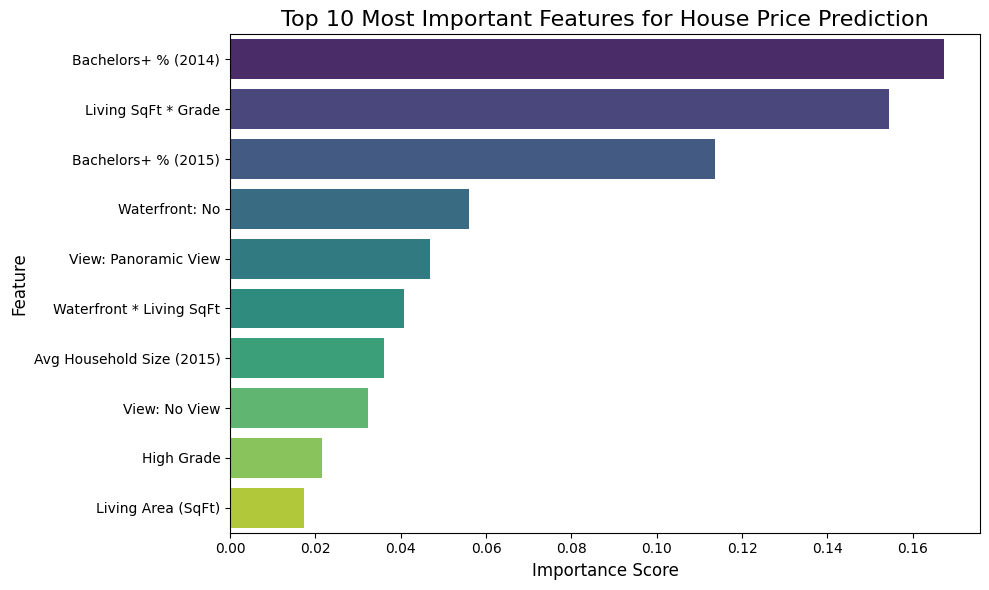

In [118]:
feature_importance_df['Feature'] = feature_importance_df['Feature'].str.replace('num__', '') # Replace processing names
feature_importance_df['Feature'] = feature_importance_df['Feature'].str.replace('cat__', '') # Replace processing names

# Dictionary defining how to rename the column names in the feature dataset
rename_map = {
    'sqft_living': 'Living Area (SqFt)',
    'sqft_lot': 'Lot Size (SqFt)',
    'bedrooms': 'Number of Bedrooms',
    'bathrooms': 'Number of Bathrooms',
    'floors': 'Number of Floors',
    'sqft_basement': 'Basement Area (SqFt)',
    'lat': 'Latitude',
    'long': 'Longitude',
    'sqft_living15': 'Avg. Living Area (15 Neighbors)',
    'sqft_lot15': 'Avg. Lot Size (15 Neighbors)',

    'view_0': 'View Quality: None',
    'view_1': 'View Quality: Fair',
    'view_2': 'View Quality: Good',
    'view_3': 'View Quality: Excellent',
    'view_4': 'View Quality: Panoramic',

    'condition_1': 'Condition: Very Poor',
    'condition_2': 'Condition: Poor',
    'condition_3': 'Condition: Average',
    'condition_4': 'Condition: Good',
    'condition_5': 'Condition: Excellent',

    'grade_1': 'Grade: Poor Quality',
    'grade_3': 'Grade: Basic Construction',
    'grade_4': 'Grade: Low Quality',
    'grade_5': 'Grade: Below Average Quality',
    'grade_6': 'Grade: Average Quality',
    'grade_7': 'Grade: Good Quality',
    'grade_8': 'Grade: Very Good Quality',
    'grade_9': 'Grade: Excellent Quality',
    'grade_10': 'Grade: Superior Quality',
    'grade_11': 'Grade: Custom Build Quality',
    'grade_12': 'Grade: Luxury Quality',
    'grade_13': 'Grade: Mansion Quality',

    'waterfront_0': 'Waterfront: No',
    'waterfront_1': 'Waterfront: Yes',

    'sqft_living_x_grade': 'Living Area x Quality Grade',
    'waterfront_x_sqft_living': 'Waterfront x Living Area Interaction',
    'has_basement': 'Property Has a Basement',
    'age_at_sale': 'Property Age at Time of Sale',

    'sale_year': 'Sale Year',
    'sale_month': 'Sale Month',
    'sale_day': 'Sale Day',
    'high_grade': 'High Grade',

    'median_income': 'Census: Median Household Income',
    'avg_household_size_2015': 'Census: Avg Household Size (2015)',
    'percent_married_2015': 'Census: Married Pop. % (2015)',
    'housing_units_2015': 'Census: Housing Units (2015)',
    'percent_owner_occupied_2015': 'Census: Owner Occupied % (2015)',
    'percent_renter_occupied_2015': 'Census: Renter Occupied % (2015)',
    'unemployment_rate_2015': 'Census: Unemployment Rate (2015)',
    'percent_hs_grad_or_higher_2015': 'Census: HS Grad+ % (2015)',
    'percent_bachelors_or_higher_2015': 'Census: Bachelors+ % (2015)',
    'avg_household_size_2014': 'Census: Avg Household Size (2014)',
    'percent_married_2014': 'Census: Married Pop. % (2014)',
    'housing_units_2014': 'Census: Housing Units (2014)',
    'percent_owner_occupied_2014': 'Census: Owner Occupied % (2014)',
    'percent_renter_occupied_2014': 'Census: Renter Occupied % (2014)',
    'unemployment_rate_2014': 'Census: Unemployment Rate (2014)',
    'percent_hs_grad_or_higher_2014': 'Census: HS Grad+ % (2014)',
    'percent_bachelors_or_higher_2014': 'Census: Bachelors+ % (2014)',
}

# Rename the columns
feature_importance_df['Feature'] = feature_importance_df['Feature'].replace(rename_map)

# Rename the zipcode columns to be more readable
feature_importance_df['Feature'] = feature_importance_df['Feature'].apply(
    lambda x: f"Zipcode: {x.split('_')[1]}" if x.startswith('zipcode_') else x
)

top_10_features = feature_importance_df.head(10)

print("\nFeature Importances for Real Estate Agency (Top 10):")
print(top_10_features)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
plt.title('Top 10 Most Important Features for House Price Prediction', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [92]:
#model_filename = 'final_model.pkl'

# Save the entire pipeline (including preprocessor and regressor)
#with open(model_filename, 'wb') as file:
#    pickle.dump(final_pipeline, file)

#print(f"\nBest model saved to {model_filename}")

In [93]:
comparison_df = pd.DataFrame({
    'Actual_Price': y_test,
    'Predicted_Price': y_pred_test
})
comparison_df['Absolute_Error'] = abs(comparison_df['Actual_Price'] - comparison_df['Predicted_Price']) # Calculates the absolute difference between actual and predicted prices.
comparison_df['Percentage_Error'] = (comparison_df['Absolute_Error'] / comparison_df['Actual_Price']) * 100 # Calculates the percentage error, showing the error relative to the actual price.
print("\nActual vs. Predicted Prices with Errors")
print(comparison_df.head())


Actual vs. Predicted Prices with Errors
       Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error
10650      825000.0     803392.93750     21607.06250          2.619038
2041       532500.0     488948.31250     43551.68750          8.178721
8668       435000.0     540462.81250    105462.81250         24.244325
1114       216000.0     231873.84375     15873.84375          7.349002
13902      525000.0     659467.25000    134467.25000         25.612810


In [94]:
comparison_df = pd.DataFrame({
    'Actual_Price': y_test,
    'Predicted_Price': y_pred_test
})
comparison_df['Absolute_Error'] = abs(comparison_df['Actual_Price'] - comparison_df['Predicted_Price'])
comparison_df['Percentage_Error'] = (comparison_df['Absolute_Error'] / comparison_df['Actual_Price']) * 100
print("\n--- Actual vs. Predicted Prices with Errors ---")
print(comparison_df.head())


--- Actual vs. Predicted Prices with Errors ---
       Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error
10650      825000.0     803392.93750     21607.06250          2.619038
2041       532500.0     488948.31250     43551.68750          8.178721
8668       435000.0     540462.81250    105462.81250         24.244325
1114       216000.0     231873.84375     15873.84375          7.349002
13902      525000.0     659467.25000    134467.25000         25.612810


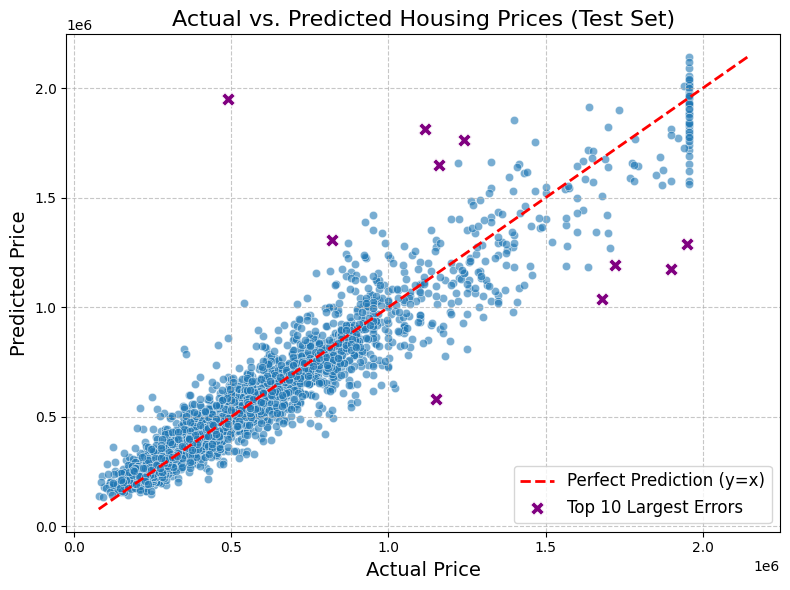

In [95]:
plt.figure(figsize=(8, 6))

sns.scatterplot(x='Actual_Price', y='Predicted_Price', data=comparison_df, alpha=0.6)

max_price = max(comparison_df['Actual_Price'].max(), comparison_df['Predicted_Price'].max())
min_price = min(comparison_df['Actual_Price'].min(), comparison_df['Predicted_Price'].min())
plt.plot([min_price, max_price], [min_price, max_price], color='red', linestyle='--', linewidth=2, label='Perfect Prediction (y=x)')

top_error_indices = comparison_df.sort_values(by='Absolute_Error', ascending=False).head(10).index


sns.scatterplot(x='Actual_Price', y='Predicted_Price', data=comparison_df.loc[top_error_indices],
                color='purple', s=100, marker='X', label='Top 10 Largest Errors', zorder=5)

plt.title('Actual vs. Predicted Housing Prices (Test Set)', fontsize=16)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [96]:
top_10_error_indices = comparison_df.sort_values(by='Absolute_Error', ascending=False).head(10).index.tolist()
print(top_10_error_indices)

[19475, 1175, 15402, 14807, 3753, 15019, 14250, 9722, 12754, 12344]


In [97]:
print("\nFeatures of Houses with Top 10 Largest Errors")
print(X_test.loc[top_10_error_indices])


Features of Houses with Top 10 Largest Errors
       bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
19475         5       3.50       4460.0      2975     3.0           0     2   
1175          4       2.50       3070.0      7830     2.0           0     2   
15402         4       2.50       3690.0     11191     1.0           0     3   
14807         3       2.50       2510.0     12779     1.5           0     4   
3753          4       4.25       4980.2     68257     2.0           0     0   
15019         3       2.00       2110.0     18815     2.0           0     0   
14250         5       4.00       4590.0     35046     2.0           0     0   
9722          5       3.25       4980.2     13726     2.0           0     3   
12754         3       3.00       3850.0     38830     2.0           0     1   
12344         5       3.25       4290.0      7019     2.5           0     0   

       condition  grade  sqft_basement  ... percent_hs_grad_or_higher_2015  \
19475

In [ ]:
holdout_url = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv"
holdout = pd.read_csv(holdout_url)

In [ ]:
holdout.shape

In [ ]:
def handle_age_at_sale(holdout, method='adjust'):
    if method == 'nan':
        holdout['age_at_sale'] = holdout['sale_year'] - holdout['yr_built']
        holdout.loc[holdout['age_at_sale'] < 0, 'age_at_sale'] = np.nan
    elif method == 'zero':
        holdout['age_at_sale'] = holdout['sale_year'] - holdout['yr_built']
        holdout.loc[holdout['age_at_sale'] < 0, 'age_at_sale'] = 0
    elif method == 'adjust':
        holdout.loc[holdout['yr_built'] > holdout['sale_year'], 'yr_built'] = holdout['sale_year']
        holdout['age_at_sale'] = holdout['sale_year'] - holdout['yr_built']
    else:
        raise ValueError("Method must be 'nan', 'zero', or 'adjust'")
    return holdout

In [ ]:
holdout['date'] = pd.to_datetime(holdout['date'].str.replace('T000000', ''), errors='coerce')
holdout['sale_year'] = holdout['date'].dt.year
holdout['sale_month'] = holdout['date'].dt.month
holdout['sale_day'] = holdout['date'].dt.dayofweek
holdout['renovated'] = holdout['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
holdout['low_grade'] = (holdout['grade'] <= 3).astype(int)
holdout['high_grade'] = (holdout['grade'] >= 11).astype(int)
holdout['sqft_living_x_grade'] = holdout['sqft_living'] * df['grade']
holdout['waterfront_x_sqft_living'] = holdout['waterfront'] * df['sqft_living']
holdout['has_basement'] = np.where(holdout['sqft_basement'] > 0, 1, 0)

In [ ]:
holdout = handle_age_at_sale(holdout, method='adjust')
holdout.loc[holdout['id'] == 2402100895, 'bedrooms'] = 3
print(holdout[holdout['yr_built'] > holdout['sale_year']][['date', 'yr_built', 'sale_year']])

In [ ]:
holdout['zipcode'] = holdout['zipcode'].astype(str).str.zfill(5)

url = f'https://api.census.gov/data/2022/acs/acs5?get=NAME,B19013_001E&for=zip%20code%20tabulation%20area:*&key={api_key}'
response = requests.get(url)

if response.status_code == 200:
    income_data = response.json()
    income_df = pd.DataFrame(income_data[1:], columns=income_data[0])
    income_df = income_df.rename(columns={'B19013_001E': 'median_income', 'zip code tabulation area': 'zipcode'})
    income_df['zipcode'] = income_df['zipcode'].astype(str).str.zfill(5)
    income_df['median_income'] = pd.to_numeric(income_df['median_income'], errors='coerce')

    holdout = holdout.merge(income_df[['zipcode', 'median_income']], on='zipcode', how='left')
    print(holdout[['zipcode', 'median_income']].head())
else:
    print("Error fetching data:", response.status_code)
    print("Response content:", response.text)

In [ ]:
holdout['zipcode'] = holdout['zipcode'].astype(str).str.zfill(5)
url_2015 = 'https://api.census.gov/data/2015/acs/acs5?get=B25010_001E,B12001_001E,B12001_003E,B25001_001E,B25003_002E,B25003_003E,B23025_003E,B23025_005E,B15002_001E,B15002_010E,B15002_011E,B15002_012E,B15002_013E,B15002_014E,B15002_015E,B15002_016E,B15002_017E,B15002_018E,B15002_019E,B15002_020E,B15002_021E,B15002_022E,B15002_023E,B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E&for=zip%20code%20tabulation%20area:*'
response_2015 = requests.get(url_2015)

if response_2015.status_code == 200:
    data_2015 = response_2015.json()
    df_census_2015 = pd.DataFrame(data_2015[1:], columns=data_2015[0])

    numeric_cols_2015 = [col for col in df_census_2015.columns if col.startswith('B')]
    df_census_2015[numeric_cols_2015] = df_census_2015[numeric_cols_2015].apply(pd.to_numeric, errors='coerce')

    df_census_2015 = df_census_2015.rename(columns={'zip code tabulation area': 'zipcode'})
    df_census_2015['zipcode'] = df_census_2015['zipcode'].astype(str).str.zfill(5)

    df_census_2015['avg_household_size_2015'] = df_census_2015['B25010_001E']
    df_census_2015['percent_married_2015'] = (df_census_2015['B12001_003E'] / df_census_2015['B12001_001E']) * 100
    df_census_2015['housing_units_2015'] = df_census_2015['B25001_001E']
    total_occupied_2015 = df_census_2015['B25003_002E'] + df_census_2015['B25003_003E']
    df_census_2015['percent_owner_occupied_2015'] = (df_census_2015['B25003_002E'] / total_occupied_2015) * 100
    df_census_2015['percent_renter_occupied_2015'] = (df_census_2015['B25003_003E'] / total_occupied_2015) * 100
    df_census_2015['unemployment_rate_2015'] = (df_census_2015['B23025_005E'] / df_census_2015['B23025_003E']) * 100

    hs_total_2015 = (df_census_2015['B15002_010E'] + df_census_2015['B15002_011E'] + df_census_2015['B15002_012E'] +
                     df_census_2015['B15002_013E'] + df_census_2015['B15002_014E'] + df_census_2015['B15002_015E'] +
                     df_census_2015['B15002_016E'] + df_census_2015['B15002_017E'] + df_census_2015['B15002_018E'] +
                     df_census_2015['B15002_019E'] + df_census_2015['B15002_020E'] + df_census_2015['B15002_021E'] +
                     df_census_2015['B15002_022E'] + df_census_2015['B15002_023E'])
    df_census_2015['percent_hs_grad_or_higher_2015'] = (hs_total_2015 / df_census_2015['B15002_001E']) * 100

    total_bachelors_or_higher_2015 = (df_census_2015['B15003_017E'] + df_census_2015['B15003_018E'] +
                                      df_census_2015['B15003_019E'] + df_census_2015['B15003_020E'])

    df_census_2015['percent_bachelors_or_higher_2015'] = (total_bachelors_or_higher_2015 / df_census_2015['B15003_001E']) * 100


    holdout = holdout.merge(df_census_2015[['zipcode', 'avg_household_size_2015', 'percent_married_2015',
                                                'housing_units_2015', 'percent_owner_occupied_2015',
                                                'percent_renter_occupied_2015', 'unemployment_rate_2015',
                                                'percent_hs_grad_or_higher_2015', 'percent_bachelors_or_higher_2015']],
                                  on='zipcode', how='left')

    print("\n2015 Census data merged with holdout. Head:")
    print(holdout.head())

else:
    print("Error fetching 2015 Census data:", response_2015.status_code)
    print("Response content:", response_2015.text)


url_2014 = 'https://api.census.gov/data/2014/acs/acs5?get=B25010_001E,B12001_001E,B12001_003E,B25001_001E,B25003_002E,B25003_003E,B23025_003E,B23025_005E,B15002_001E,B15002_010E,B15002_011E,B15002_012E,B15002_013E,B15002_014E,B15002_015E,B15002_016E,B15002_017E,B15002_018E,B15002_019E,B15002_020E,B15002_021E,B15002_022E,B15002_023E,B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E&for=zip%20code%20tabulation%20area:*'

response_2014 = requests.get(url_2014)

if response_2014.status_code == 200:
    data_2014 = response_2014.json()
    df_census_2014 = pd.DataFrame(data_2014[1:], columns=data_2014[0])

    numeric_cols_2014 = [col for col in df_census_2014.columns if col.startswith('B')]
    df_census_2014[numeric_cols_2014] = df_census_2014[numeric_cols_2014].apply(pd.to_numeric, errors='coerce')

    df_census_2014 = df_census_2014.rename(columns={'zip code tabulation area': 'zipcode'})
    df_census_2014['zipcode'] = df_census_2014['zipcode'].astype(str).str.zfill(5)

    df_census_2014['avg_household_size_2014'] = df_census_2014['B25010_001E']
    df_census_2014['percent_married_2014'] = (df_census_2014['B12001_003E'] / df_census_2014['B12001_001E']) * 100
    df_census_2014['housing_units_2014'] = df_census_2014['B25001_001E']
    total_occupied_2014 = df_census_2014['B25003_002E'] + df_census_2014['B25003_003E']
    df_census_2014['percent_owner_occupied_2014'] = (df_census_2014['B25003_002E'] / total_occupied_2014) * 100
    df_census_2014['percent_renter_occupied_2014'] = (df_census_2014['B25003_003E'] / total_occupied_2014) * 100
    df_census_2014['unemployment_rate_2014'] = (df_census_2014['B23025_005E'] / df_census_2014['B23025_003E']) * 100

    hs_total_2014 = (df_census_2014['B15002_010E'] + df_census_2014['B15002_011E'] + df_census_2014['B15002_012E'] +
                     df_census_2014['B15002_013E'] + df_census_2014['B15002_014E'] + df_census_2014['B15002_015E'] +
                     df_census_2014['B15002_016E'] + df_census_2014['B15002_017E'] + df_census_2014['B15002_018E'] +
                     df_census_2014['B15002_019E'] + df_census_2014['B15002_020E'] + df_census_2014['B15002_021E'] +
                     df_census_2014['B15002_022E'] + df_census_2014['B15002_023E'])
    df_census_2014['percent_hs_grad_or_higher_2014'] = (hs_total_2014 / df_census_2014['B15002_001E']) * 100

    total_bachelors_or_higher_2014 = (df_census_2014['B15003_017E'] + df_census_2014['B15003_018E'] +
                                      df_census_2014['B15003_019E'] + df_census_2014['B15003_020E'])
    df_census_2014['percent_bachelors_or_higher_2014'] = (total_bachelors_or_higher_2014 / df_census_2014['B15003_001E']) * 100


    holdout = holdout.merge(df_census_2014[['zipcode', 'avg_household_size_2014', 'percent_married_2014',
                                                'housing_units_2014', 'percent_owner_occupied_2014',
                                                'percent_renter_occupied_2014', 'unemployment_rate_2014',
                                                'percent_hs_grad_or_higher_2014', 'percent_bachelors_or_higher_2014']],
                                  on='zipcode', how='left')

    print("\n2014 Census data merged with holdout. Head:")
    print(holdout.head())

else:
    print("Error fetching 2014 Census data:", response_2014.status_code)
    print("Response content:", response_2014.text)

In [ ]:
for col in ['sqft_living', 'sqft_lot']:
    holdout[col] = holdout[col].clip(upper=holdout[col].quantile(0.99))

In [ ]:
cols_to_drop = [
    'id', 'date', 'yr_built', 'yr_renovated', 'sqft_above', # Defines a list of columns to be removed from the feature set.
]

holdout_X = holdout.drop(columns=cols_to_drop)

# Define categorical features
cat_features = ['zipcode', 'view', 'condition', 'grade', 'waterfront']

# Identify numerical features automatically (excluding categoricals)
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist() # Automatically selects all columns with integer or float data types from the original 'X' (training features).
num_features = [col for col in num_features if col not in cat_features] # Filters the automatically identified numerical features to exclude those already defined as categorical.

print("Numerical Features:", num_features)
print("Categorical Features:", cat_features)

In [ ]:
y_pred_holdout = best_pipeline.predict(holdout_X)

print("\nData split into training and testing sets.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

In [ ]:
predictions_df = pd.DataFrame({'price': y_pred_holdout})
predictions_df.head()

In [ ]:
predictions_df.to_csv('predicted_prices.csv', index=False)